In [1]:
!git clone https://github.com/aoi3142/Waterfall.git


Cloning into 'Waterfall'...
remote: Enumerating objects: 233, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 233 (delta 123), reused 104 (delta 81), pack-reused 78 (from 1)
Receiving objects: 100% (233/233), 1.90 MiB | 27.04 MiB/s, done.
Resolving deltas: 100% (152/152), done.


In [2]:
!ls Waterfall


Images	     LICENSE	     README.md	       waterfall
__init__.py  pyproject.toml  requirements.txt


In [3]:
!pip install -r Waterfall/requirements.txt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 127.6 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.1
    Uninstalling transformers-4.57.1:
      Successfully uninstalled transformers-4.57.1


In [1]:
import sys
sys.path.append('/content/Waterfall')
from waterfall.watermark import watermark_texts, verify_texts


In [12]:
!ls /content/Waterfall/waterfall



__init__.py  WatermarkerBase.py        WatermarkingFnSquare.py
permute.py   WatermarkingFnFourier.py  watermark.py
__pycache__  WatermarkingFn.py


In [2]:
import waterfall.watermark as wf
wf.watermark_texts.__defaults__ = tuple(
    "microsoft/Phi-3-mini-4k-instruct" if d == "meta-llama/Llama-3.1-8B-Instruct" else d
    for d in wf.watermark_texts.__defaults__
)
wf.verify_texts.__defaults__ = tuple(
    "microsoft/Phi-3-mini-4k-instruct" if d == "meta-llama/Llama-3.1-8B-Instruct" else d
    for d in wf.verify_texts.__defaults__
)


In [13]:
from waterfall.watermark import watermark_texts, verify_texts

texts = ["This is a quick test for Waterfall watermarking."]

wm_texts = watermark_texts(
    texts,
    id=42,
    kappa=0.6,
    # model_path="gpt2",
    model_path="microsoft/Phi-3-mini-4k-instruct",# smaller model fits on RTX 2080
    device="cuda"
)

print("✅ Watermarked text:\n", wm_texts[0])

# Optional verification check
scores = verify_texts(wm_texts, id=42)
print("\nVerification scores:", scores)



✅ Watermarked text:
 "This serves as an expedited evaluation for Waterfall watermarking."

Verification scores: [0.24831021]


In [14]:
# Install and import required libraries
from waterfall.watermark import watermark_texts, verify_texts
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import numpy as np
import matplotlib.pyplot as plt
import torch

# Configuration
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL = "microsoft/Phi-3-mini-4k-instruct"
ID = 42
KAPPAS = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]

print("Using device:", DEVICE)


Using device: cuda


In [5]:
# Five short, diverse texts for analysis
texts = [
    "Explain how model extraction attacks can replicate proprietary LLMs.",
    "Summarize the importance of digital watermarks in identifying AI-generated text.",
    "Describe how paraphrasing can weaken watermark signals in generated outputs.",
    "Discuss the ethical risks of training AI systems on copyrighted or private data.",
    "Outline key detection techniques for tracing redistributed LLM-generated content.",
    "Explain why watermarking may help track the origin of leaked AI outputs.",
    "Describe how text watermarks embed hidden statistical patterns in model output.",
    "Summarize challenges of designing robust watermarking systems for large models.",
    "Explain how adversarial paraphrasing can disrupt statistical watermark traces.",
    "Discuss how provenance tracking supports accountability in AI text generation.",
    "Describe a use case where watermarked text aids in identifying misuse of LLM APIs.",
    "Explain how embedding-based verification differs from lexical watermarking.",
    "Discuss how open-source LLMs complicate watermark enforcement across ecosystems.",
    "Outline why semantic similarity is used when paraphrasing watermarked text.",
    "Explain how beam search diversity affects watermark signal preservation.",
    "Describe why watermark strength (kappa) influences detection reliability.",
    "Summarize how cosine similarity helps measure semantic drift after paraphrasing.",
    "Explain trade-offs between robustness and imperceptibility in watermarking.",
    "Discuss how verifying watermark confidence can detect text tampering.",
    "Describe future research directions for scalable text watermark verification."
]
print("Total texts:", len(texts))

Total texts: 20


In [6]:
# Generate unwatermarked baseline and watermarked variants
score_data = {}

# Baseline (unwatermarked)
unwm = watermark_texts(texts, id=ID, kappa=0.0, model_path=MODEL, device=DEVICE)
unwm_scores = verify_texts(unwm, id=ID)
score_data["unwatermarked"] = unwm_scores

# Watermarked at three strengths
for k in KAPPAS:
    wm_texts = watermark_texts(texts, id=ID, kappa=k, model_path=MODEL, device=DEVICE)
    wm_scores = verify_texts(wm_texts, id=ID)
    score_data[f"kappa={k}"] = wm_scores
    print(f"✅ Done for kappa={k} | mean score: {np.mean(wm_scores):.3f}")


✅ Done for kappa=0.2 | mean score: 0.131
✅ Done for kappa=0.4 | mean score: 0.175
✅ Done for kappa=0.6 | mean score: 0.210
✅ Done for kappa=0.8 | mean score: 0.263
✅ Done for kappa=1.0 | mean score: 0.293
✅ Done for kappa=1.2 | mean score: 0.361
✅ Done for kappa=1.4 | mean score: 0.389
✅ Done for kappa=1.6 | mean score: 0.432
✅ Done for kappa=1.8 | mean score: 0.468
✅ Done for kappa=2.0 | mean score: 0.512


In [7]:
# Load a small paraphraser model
PARAPHRASE_MODEL = "Vamsi/T5_Paraphrase_Paws"
tok = AutoTokenizer.from_pretrained(PARAPHRASE_MODEL)
par = AutoModelForSeq2SeqLM.from_pretrained(PARAPHRASE_MODEL).to(DEVICE)

def paraphrase_batch(texts):
    outputs = []
    for t in texts:
        inp = "paraphrase: " + t + " </s>"
        enc = tok([inp], return_tensors="pt", padding=True, truncation=True).to(DEVICE)
        gen = par.generate(**enc, max_length=160, num_beams=4, early_stopping=True)
        outputs.append(tok.decode(gen[0], skip_special_tokens=True))
    return outputs

# Attack kappa=0.6 watermarked texts
wm_texts_06 = watermark_texts(texts, id=ID, kappa=0.6, model_path=MODEL, device=DEVICE)
paraphrased_texts = paraphrase_batch(wm_texts_06)
paraphrased_scores = verify_texts(paraphrased_texts, id=ID)
score_data["paraphrased k=0.6"] = paraphrased_scores


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

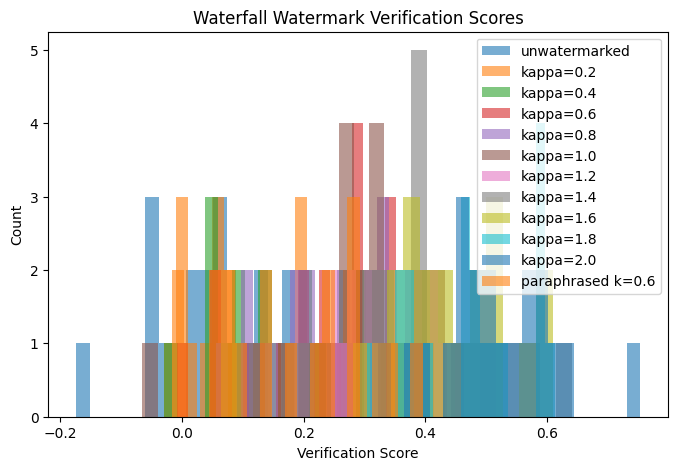

In [8]:
# Plot histogram comparison
plt.figure(figsize=(8, 5))
for label, scores in score_data.items():
    plt.hist(scores, bins=20, alpha=0.6, label=label)
plt.title("Waterfall Watermark Verification Scores")
plt.xlabel("Verification Score")
plt.ylabel("Count")
plt.legend()
plt.show()


In [9]:
# Compute mean and standard deviation for each condition
for label, scores in score_data.items():
    print(f"{label:20s} | mean = {np.mean(scores):.4f} | std = {np.std(scores):.4f}")


unwatermarked        | mean = 0.0648 | std = 0.1087
kappa=0.2            | mean = 0.1308 | std = 0.1129
kappa=0.4            | mean = 0.1753 | std = 0.1176
kappa=0.6            | mean = 0.2101 | std = 0.1064
kappa=0.8            | mean = 0.2634 | std = 0.1049
kappa=1.0            | mean = 0.2926 | std = 0.1043
kappa=1.2            | mean = 0.3605 | std = 0.0778
kappa=1.4            | mean = 0.3888 | std = 0.1304
kappa=1.6            | mean = 0.4319 | std = 0.1191
kappa=1.8            | mean = 0.4678 | std = 0.0954
kappa=2.0            | mean = 0.5125 | std = 0.0947
paraphrased k=0.6    | mean = 0.1713 | std = 0.1232


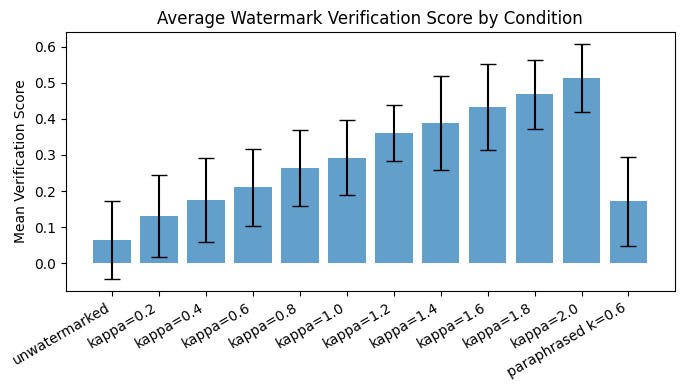

In [10]:
import numpy as np
import matplotlib.pyplot as plt

means = [np.mean(v) for v in score_data.values()]
stds = [np.std(v) for v in score_data.values()]
labels = list(score_data.keys())

plt.figure(figsize=(7,4))
plt.bar(labels, means, yerr=stds, capsize=6, alpha=0.7)
plt.ylabel("Mean Verification Score")
plt.xticks(rotation=30, ha='right')
plt.title("Average Watermark Verification Score by Condition")
plt.tight_layout()
plt.show()


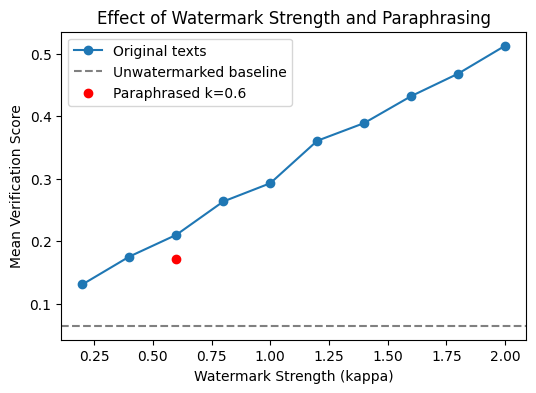

In [12]:
kappas = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
means = [np.mean(score_data.get(f'kappa={k}', [0])) for k in kappas]

plt.figure(figsize=(6,4))
plt.plot(kappas, means, marker='o', label="Original texts")
plt.axhline(np.mean(score_data['unwatermarked']), color='gray', linestyle='--', label='Unwatermarked baseline')
plt.scatter([0.6], [np.mean(score_data['paraphrased k=0.6'])], color='red', label='Paraphrased k=0.6')
plt.xlabel("Watermark Strength (kappa)")
plt.ylabel("Mean Verification Score")
plt.title("Effect of Watermark Strength and Paraphrasing")
plt.legend()
plt.show()
